# ** ->> Fake news detection <<- **

# **Environment setup and importing Libraries**

In [1]:
%%time

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug  7 13:01:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#sns.set(rc='{figure.figsize':(5,5)})
#sns.swarmplot(x=df[col1] , y=df[col2])

# **Setting up Environment**

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
#!pip install nltk
import nltk
nltk.download("stopwords")
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Baseline findings from historic tweet data**

# **Loading the historic dataset**

In [3]:
# Historic data from date range 31/3/2015 - 19/2/2018

# out of sample test on second source dataset for time period 4/5/2009 to 17/6/2020

# df_true = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
# df_fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

from google.colab import drive
drive.mount('/content/drive/')

df_true = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/True.csv')
df_fake = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/Fake.csv')

Mounted at /content/drive/


# **Preprocessing**

*   set up a target variable
*   combine real and fake news datasets



In [4]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

label                                              title  \
0    0.0  As U.S. budget fight looms, Republicans flip t...   
1    0.0  U.S. military to accept transgender recruits o...   
2    0.0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3    0.0  FBI Russia probe helped by Australian diplomat...   
4    0.0  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  target  \
0  December 31, 2017        1   
1  December 29, 2017        1   
2  December 31, 2017        1   
3  December 30, 2017        1   
4  December 29, 2017        1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

# **Checking for Null Values**

In [5]:
df.isnull().sum()

label       23481
title           0
text            0
subject         0
date            0
target          0
original        0
dtype: int64

# **Data Cleaning**

*   use of gensim library to preprocess data
*   screen out stop words
*   screen out words less than length 2



In [6]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)

    return result

In [7]:
# Transforming the unmatching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

# **Exploratory Data Analysis (EDA)**
# **Histogram for balance of true v fake news**

In [8]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

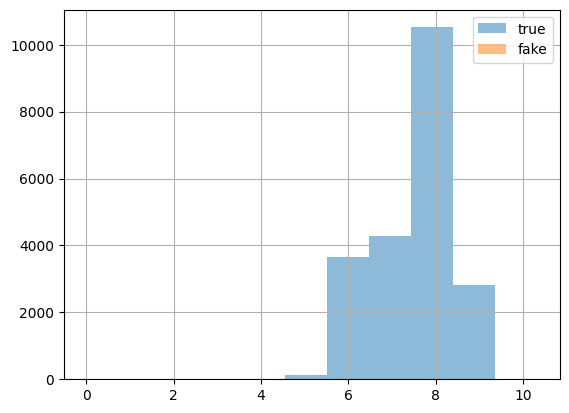

In [9]:
# histograph of True v Fake

df.loc[df['label'] == 0, 'text'].str.len().apply(np.log1p).hist(label='true', alpha=.5)
df.loc[df['label'] == 1, 'text'].str.len().apply(np.log1p).hist(label='fake', alpha=.5)
plt.legend();

# **Histogram of subjects covered**

In [10]:
sub_check = df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Number') # .sort()
sub_check = sub_check.sort_values(by=['Number'], ascending=False)
fig=px.bar(sub_check, x='subject', y='Number', color='Number', title='Number by Subject')
fig.show()

# **->>PREDICTION section / END OF EDA <<- Headline in News to predict fake or not**

In [11]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [12]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

# **Word Cloud using the Real News Headlines**

*   0 = True News headline
*   1 = True News headline



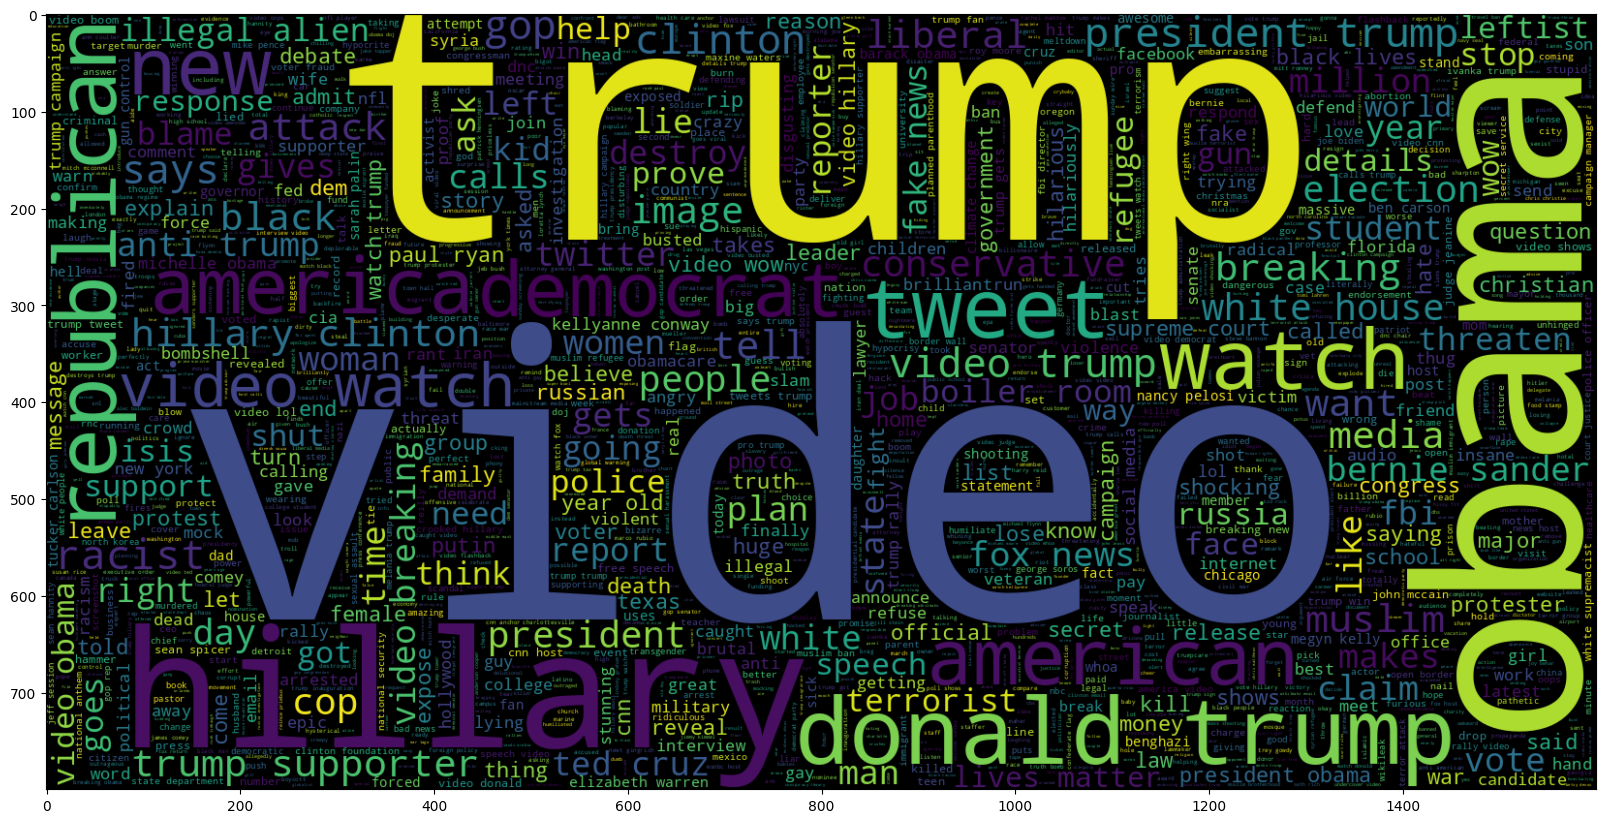

In [13]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

# **Word Cloud using the Fake News Headlines**


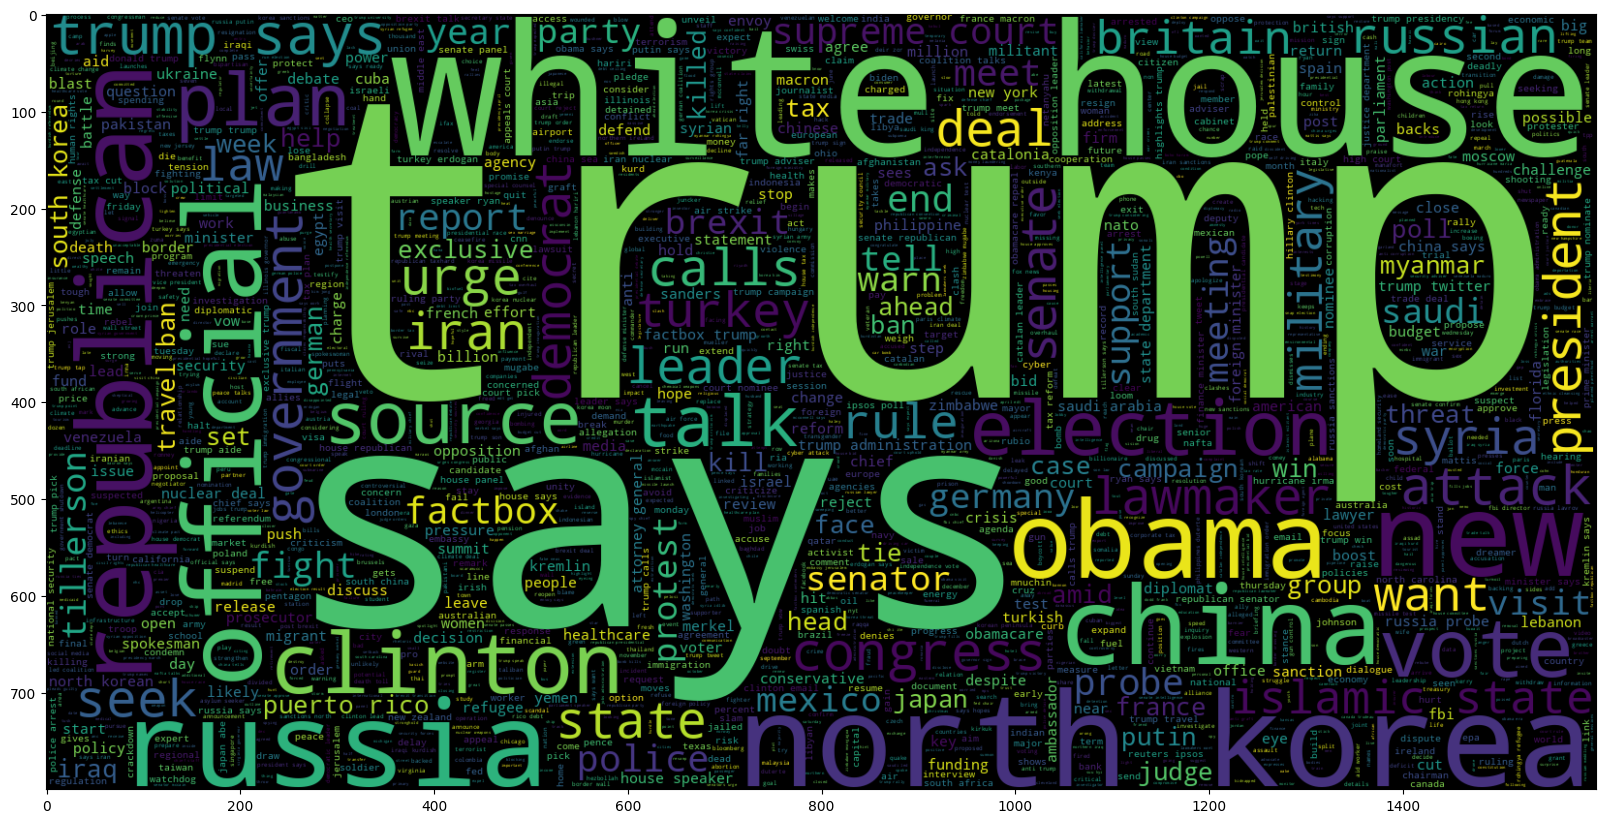

In [14]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

# **Measuring length of Titles**

In [15]:
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

The maximum number of words in a title is = 34


# **Using only the Title to predict**

# **1st Prediction - based on Title(i.e., max 34 words)**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

In [17]:
model = LogisticRegression(C=2)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print("Accuracy score = ", accuracy_value)
f1_score_value = f1_score(y_test, predicted_value, average='macro')
print("F1_score = ", f1_score_value)
precision_score_value = precision_score(y_test, predicted_value, average='macro')
print("Precison score = ", precision_score_value)

Accuracy score =  0.9475838516986892
F1_score =  0.9472458762778595
Precison score =  0.9470268669868982


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# **1st Confusion Matrix**
![](https://images.sadhguru.org/sites/default/files/media_files/iso/en/48257-confusion-clarity-spiritual-path.jpg)

<Axes: >

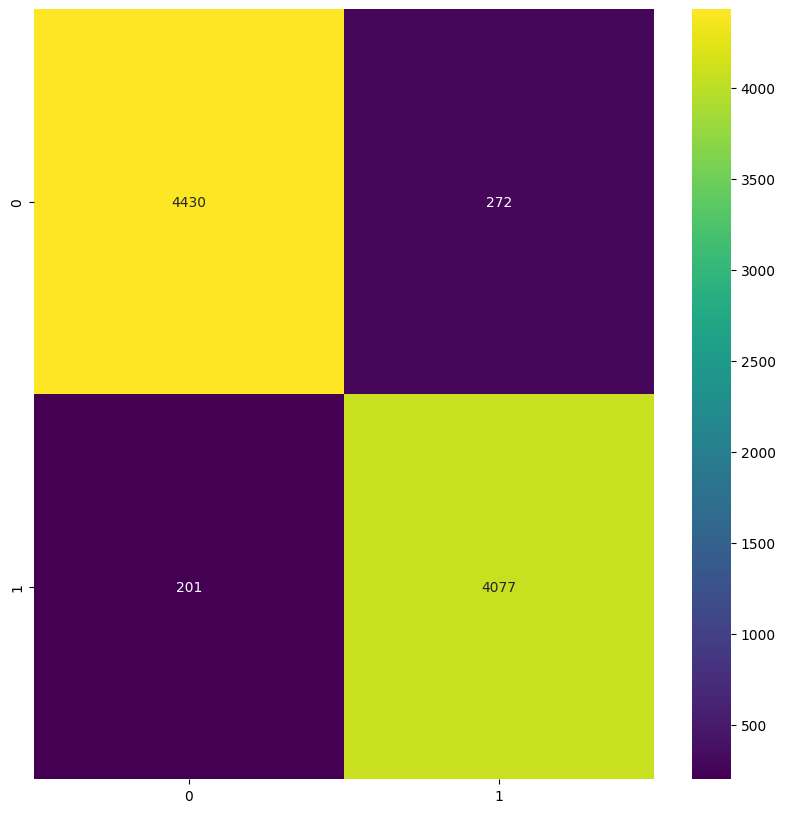

In [18]:
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='viridis')

# **Expanding the input to Text (i.e. be more than just the Title)**

*   using gensim preprocess


In [19]:
df['clean_text'] = df['text'].apply(preprocess)
df['clean_joined_text']=df['clean_text'].apply(lambda x:" ".join(x))

# **Word Cloud for Fake News based on Text**

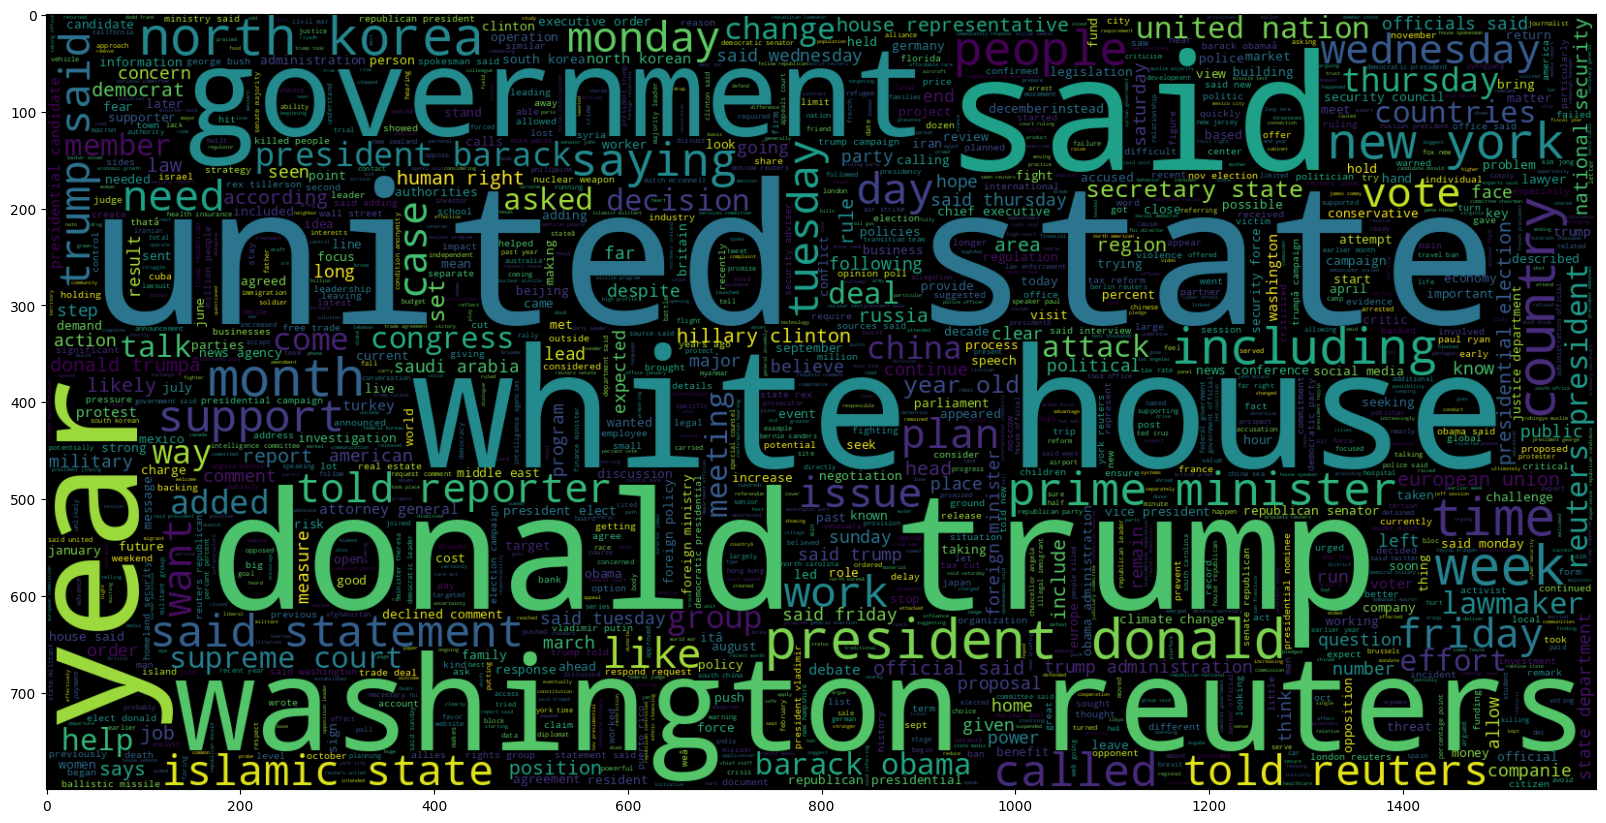

In [20]:
#Commented out as is not necessary

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

# **Word Cloud for Fake News based on Text**

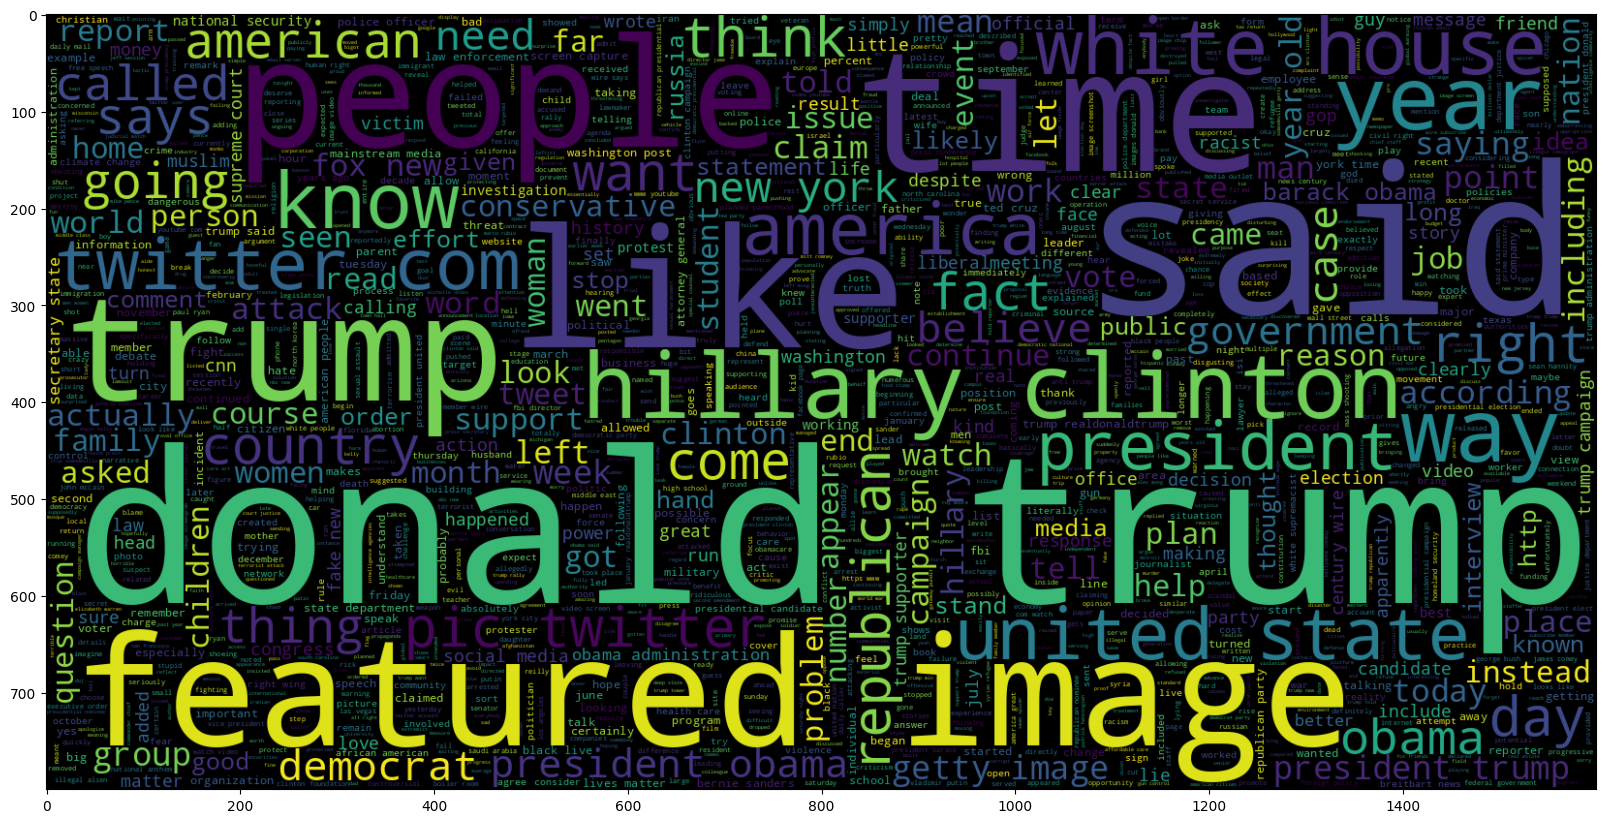

In [21]:
# Commented out as is not necessary

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

# **Distribution of word counts in the Texts**

In [22]:
#Commented out - as takes 15+ minutes to run

maxlen = -1
for doc in df.clean_joined_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a Tweet Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins = 50)
fig.show()

The maximum number of words in a Tweet Content is = 4573


# **2nd Prediction based on Text (i.e., more words than just title)**

In [23]:
#prediction based on Text 100-200 words vs only Title 8 words max

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)
print("Accuracy score = ", accuracy_value)
f1_score_value = f1_score(y_test, predicted_value, average='macro')
print("F1_score = ", f1_score_value)
precision_score_value = precision_score(y_test, predicted_value, average='macro')
print("Precison score = ", precision_score_value)

0.996503283394869
Accuracy score =  0.996503283394869
F1_score =  0.9965399136276033
Precison score =  0.996577763310009


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# **2nd The Confusion Matrix**

<Axes: >

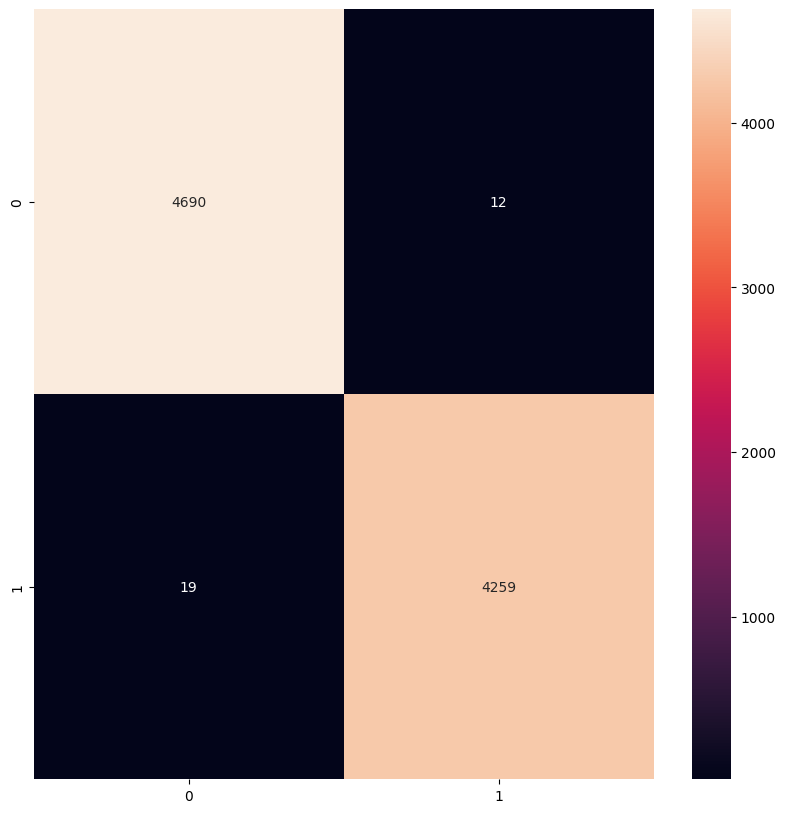

In [24]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

# **3rd - Prediction - Title and Text combined**

In [25]:
df['clean_final'] = df['original'].apply(preprocess)
df['clean_joined_final']=df['clean_final'].apply(lambda x:" ".join(x))

In [26]:
#prediction based on Text 100-200 words vs only Title 8 words max

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)
print("Accuracy score = ", accuracy_value)
f1_score_value = f1_score(y_test, predicted_value, average='macro')
print("F1_score = ", f1_score_value)
precision_score_value = precision_score(y_test, predicted_value, average='macro')
print("Precison score = ", precision_score_value)

0.996035775213476
Accuracy score =  0.996035775213476
F1_score =  0.9960932826649207
Precison score =  0.9961538004445567


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



<Axes: >

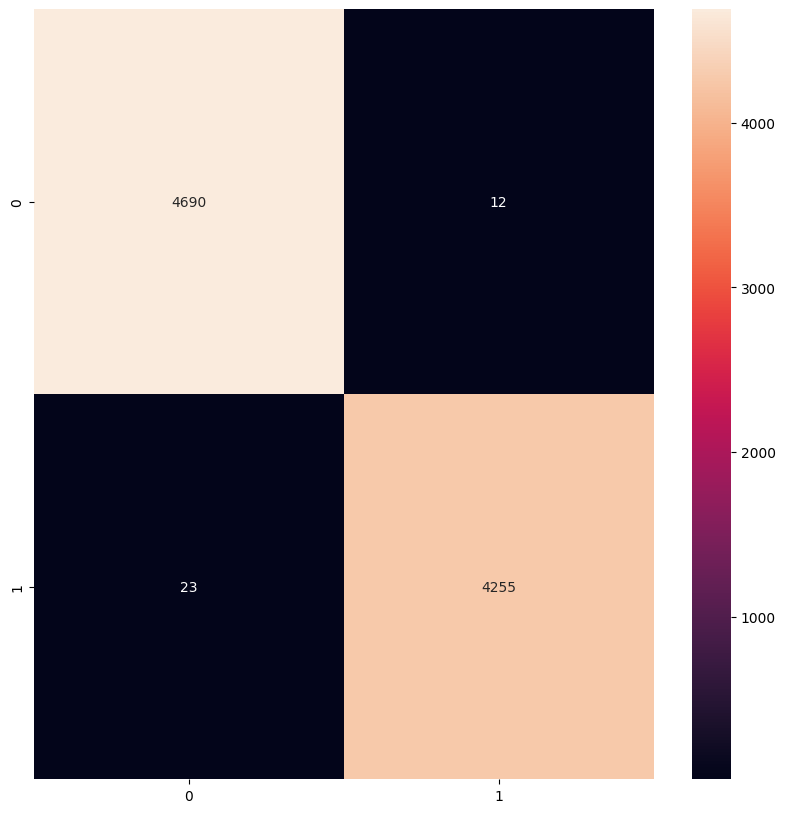

In [27]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

# **Above establishes baseline from historic tweet data**

# **Section with NEW Data from X / Tweeter to predict upon**

In [28]:
# STEP#1 - Libraries

#from config import *
import tweepy
import datetime

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
#!pip install nltk
import nltk
nltk.download("stopwords")
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **New Tweets - from 20/2/2018 to 17/6/2020**

In [29]:
# NEW code 12/6/2024

from google.colab import drive
drive.mount('/content/drive/')

df_tweets = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/trump_tweets_20-2-2018_to_17-6-2020.csv')  # , rows=200)  #  trump_tweets_20-2-2018_ to_17-6-2020

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [30]:
df_new = df_tweets

In [31]:
df_new.dropna(axis=1, how='all', inplace=True) #, ignore_index=False

#df_new.dropna()

In [32]:
df_new.isnull().sum()

id              0
link            0
content         0
date            0
retweets        0
favorites       0
mentions     7749
hashtags     9124
dtype: int64

In [33]:
# Step 3b - Joining cleaned words

pd.set_option("max_colwidth", 300)
df_new['clean_text'] = df_new['content'].apply(preprocess) # ORIGINAL
#df_new['clean_text'] = bytes(df_new['Text'], 'utf8').apply(preprocess) # values['U'].apply(preprocess)
#df_new['clean_text'] = str(bytes(df_new['Text']), 'utf8').apply(preprocess) # values['U'].apply(preprocess)
#df_new['clean_text'] = df_new['Text'].encode('utf8').apply(preprocess) # values['U'].apply(preprocess)
df_new['clean_joined_text']=df_new['clean_text'].apply(lambda x:" ".join(x))
df_new['clean_joined_text']

0                                               thank foxandfriends great timeline failures obama administration russia including crimea syria starting win
1                                              person suggest rig america elections evidence happened past happen time invite trump stop whining case votes
2       president obama quote election thought crooked hillary going win want rock boat easily electoral college game changed russian excuse narrative dems
3                               republicans leading generic poll popular tax cuts dems want away actually want raise taxes substantially want daca want fix
4                                    matt schlapp cpac getting ready exciting event big difference days president obama held white house come long way matt
                                                                               ...                                                                         
9721                                                            

# **Model from prediction of above Fake v Truth model applied to the NEW Data of the 2024 X / Tweets ->> i.e., the input data to the graphical output** - *now to figure out how to print intelligent graphics* that are...

1.   Fast to interpret
2.   Clear
3.   Unambigous
4.   Without distractions
5.   Without confusing embelleshments



**Clean data**

In [34]:
# Clean data

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)

    return result


**Transforming data**

In [35]:
# Transforming the non matching subjects to the same notation

df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})


**Build out dataset**

1.   Make predictions
2.   Assign to target column in dataframe as a data feature



In [36]:
# Build out Dataset - make predictions and assign to target column in dataframe

import numpy as np
np.set_printoptions(threshold=np.inf)

#X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=0)

#vec_train = CountVectorizer().fit(X_train)
#X_vec_train = vec_train.transform(X_train)
#X_vec_test = vec_train.transform(X_test)

# ->> put in new tweets here ->>X_vec_test = vec_train.transform(X_test)

#model = LogisticRegression(C=3)
#model.fit(X_vec_train, y_train)

# Vectorising Text column (vs Title or Title and Text) to input to model previously traing on the static data inorder to make predictions on the new X data
X_vec_train = vec_train.transform(df_new['clean_joined_text'])
predicted_value = model.predict(X_vec_test) # it is these predicted values that are to have the graphics to be created from
#print(predicted_value.reshape(-1))

df_new['predicted_true_fake'] = 0

# for i in range(len(df_new)):
#   if predicted_value[i] == 1:
#     #df_new['target'].iloc[i] = 1
#     df_new.loc[i, 'predicted_true_fake'] = 1
#   # elif predicted_value.iloc[i] == 0:
#   #   df_new['Fake'] = 0

i = 0
for p in predicted_value:
  if p == 1:
    #df_new['target'].iloc[i] = 1
    df_new.loc[i, 'predicted_true_fake'] = 1
    i += 1
  # elif predicted_value.iloc[i] == 0:
  #   df_new['Fake'] = 0


print(df_new['predicted_true_fake'])

#df_new.info()
#df_new = df_new[0,1,2,3,4]
#df2 = df1[['A', 'C']].copy()
df_new = df_new[['id', 'content', 'clean_text', 'clean_joined_text', 'predicted_true_fake']].copy()
#df.drop(df.columns[[5:]], axis=1, inplace=True)
df_new.info()

# ADD section for EDA again here

# NOT relevant as not in training mode but prediction # accuracy_value = roc_auc_score(y_test, predicted_value)
# NOT relevant as not in training mode but prediction # print(accuracy_value)

0       1
1       1
2       1
3       1
4       1
       ..
9721    0
9722    0
9723    0
9724    0
9725    0
Name: predicted_true_fake, Length: 9726, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9726 entries, 0 to 9725
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   9726 non-null   int64 
 1   content              9726 non-null   object
 2   clean_text           9726 non-null   object
 3   clean_joined_text    9726 non-null   object
 4   predicted_true_fake  9726 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 380.0+ KB


**Clean data**

In [37]:
# Clean data - and join with a space to form 'clean_joined_title'

# line = {'Author' : author, 'Text' : text, 'Created_at' : created_at, 'Metrics' : metrics}

df_new['clean_text'] = df_new['content'].apply(preprocess)
df_new['clean_text'][0]
df_new['clean_joined_text'] = df_new['clean_text'].apply(lambda x:" ".join(x))


# **Visualisations**

# **Histogram of Balance of New Data**

In [38]:
# Balance diagram

sub_tf_df = df_new.groupby('predicted_true_fake').apply(lambda x:x['content'].count()).reset_index(name='Counts')
sub_tf_df.predicted_true_fake.replace({0:'False', 1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="predicted_true_fake", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

df_new.info()
sub_tf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9726 entries, 0 to 9725
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   9726 non-null   int64 
 1   content              9726 non-null   object
 2   clean_text           9726 non-null   object
 3   clean_joined_text    9726 non-null   object
 4   predicted_true_fake  9726 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 380.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   predicted_true_fake  2 non-null      object
 1   Counts               2 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 160.0+ bytes


# **True-Fake News - Confusion Matrix**

<Axes: >

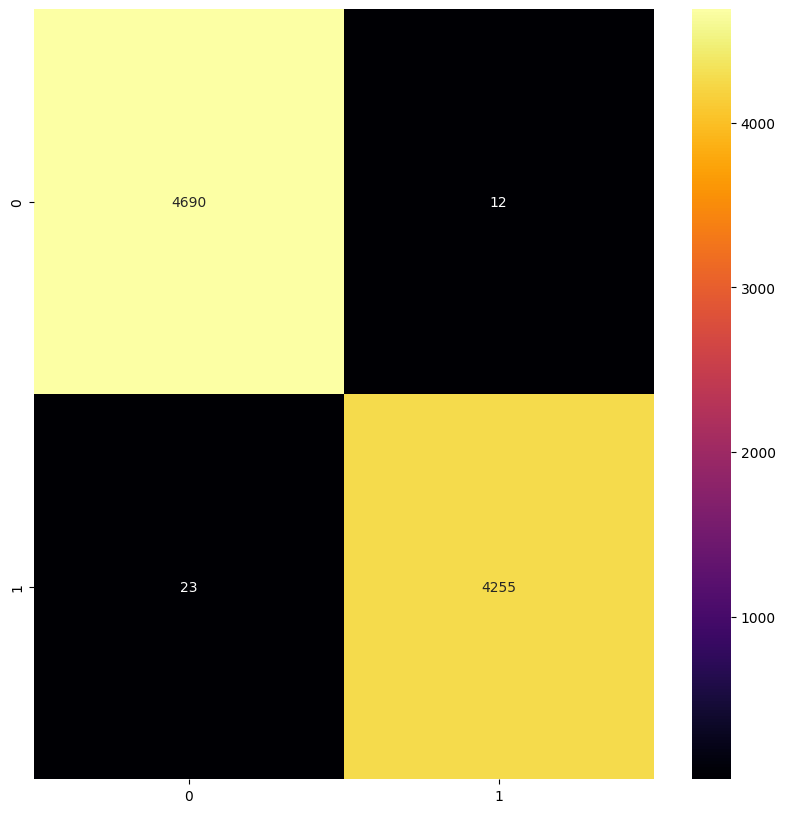

In [39]:
# Confusion Matrix

prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='inferno')

**Word Cloud**

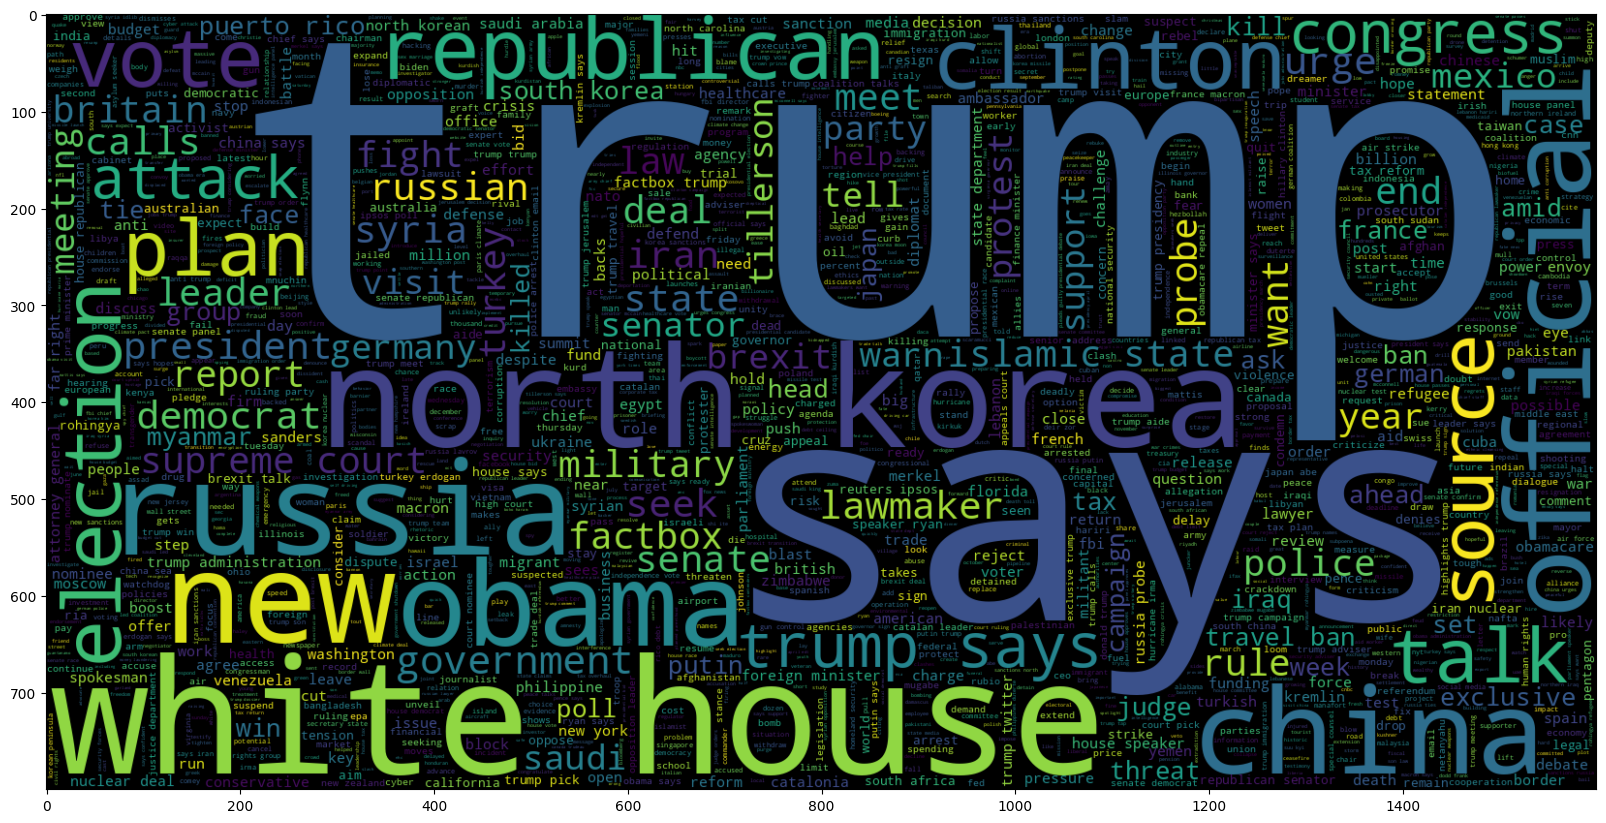

In [40]:
# Visualisation - Word Cloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')


# **Sample graphic to represent prediction of Fake v True Tweet**

<ipython-input-41-a158904e4e60>:30: UserWarning:

Attempting to set identical low and high xlims makes transformation singular; automatically expanding.



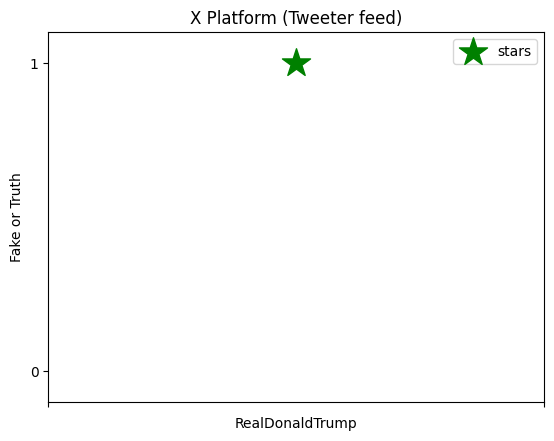

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values
y = df_new['predicted_true_fake'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]


if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "rasberry", color= "red",
            marker= "X", s=450)

if y == 1:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "stars", color= "green",
            marker= "*", s=450)


# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Fake or Truth')
# plot title
plt.title('X Platform (Tweeter feed)')
# showing legend
plt.legend()
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])

# function to show the plot
plt.show()

**Sample data**

In [42]:
df_new

id  \
0      965925223949357056   
1      965928352614965248   
2      965930611272712192   
3      965932714141650946   
4      965935035328155649   
...                   ...   
9721  1273405198698975232   
9722  1273408026968457216   
9723  1273442195161387008   
9724  1273442469066276864   
9725  1273442528411385858   

                                                                                                                                                                                                                                                                                       content  \
0                                                                                          Thank you to @ foxandfriends for the great timeline on all of the failures the Obama Administration had against Russia, including Crimea, Syria and so much more. We are now starting to win again!   
1     “There is no serious person out there who would suggest somehow that you could even rig America’s elections, there’s no evidence that that has happened in the past or that it will happen this time, and so I’d invite Mr. Trump to stop whining and make his case to get votes.” .....   
2               ....The President Obama quote just before election. That’s because he thought Crooked Hillary was going to win and he didn’t want to “rock the boat.” When I easily won the Electoral College, the whole game changed and the Russian excuse became the narrative of the Dems.   
3                                                       Republicans are now leading the Generic Poll, perhaps because of the popular Tax Cuts which the Dems want to take away. Actually, they want to raise you taxes, substantially. Also, they want to do nothing on DACA, R’s want to fix!   
4                                                                                                                   Matt Schlapp and CPAC are getting ready for another exciting event. Big difference from those days when President Obama held the White House. You’ve come a long way Matt!   
...                                                                                                                                                                                                                                                                                        ...   
9721                                                                                                                                                                                                     Joe Biden was a TOTAL FAILURE in Government. He “bungled” everything that he touched!   
9722                                                                                                                                                                                                                          Will be interviewed on @ seanhannity tonight at 9:00 P.M. Enjoy!   
9723                                                                                                                                                                                                                                                                pic.twitter.com/3lm1spbU8X   
9724                                                                                                                                                                                                                                                                pic.twitter.com/vpCE5MadUz   
9725                                                                                                                                                                                                                                                                pic.twitter.com/VLlc0BHW41   

                                                                                                                                                                     clean_text  \
0             

**Create memory for metrics i.e., save a file and add feature 1, 2(in next notebook), 3(in next notebook after notebook 2)**

In [43]:
# save prediction values to csv file to be shared with other metrics to follow i.e., stance and mis/disinformation

df_new.to_csv('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', encoding="utf-8")

# #df_new.save_csv("data_to_graph")

# import csv

# # field names
# fields = ['Author', 'Text', 'clean_text',	'clean_joined_text',	'target']  # ['Name', 'Branch', 'Year', 'CGPA']

# # data rows of csv file
# rows = df_new # [ ['Nikhil', 'COE', '2', '9.0'],
#         #  ['Sanchit', 'COE', '2', '9.1'],
#         #  ['Aditya', 'IT', '2', '9.3'],
#         #  ['Sagar', 'SE', '1', '9.5'],
#         #  ['Prateek', 'MCE', '3', '7.8'],
#         #  ['Sahil', 'EP', '2', '9.1']]

# # name of csv file
# filename = "/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv"

# # writing to csv file
# with open(filename, 'w') as csvfile:
#     # creating a csv writer object
#     csvwriter = csv.writer(csvfile)

#     # writing the fields
#     csvwriter.writerow(fields)

#     # writing the data rows
#     csvwriter.writerows(rows


# df_new.info()
# df_new.predicted_true_fake